## Sentiment Anlysis of Tweets: Natural Language Processing with TensorFlow

---

Dataset: [Tweet sentiment Dataset](https://www.kaggle.com/datasets/saurabhshahane/twitter-sentiment-dataset)

---

In [1]:
!pip install unidecode

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
%matplotlib inline

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nltk
import random
import string
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from keras.layers import Dense, Embedding, Bidirectional, LSTM
from keras.losses import SparseCategoricalCrossentropy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from unidecode import unidecode
from google.colab import drive
drive.mount('/content/drive')

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
class sentiment_classification:
  def __init__(self, dataset=None, lemmatizer = WordNetLemmatizer()):
    if dataset is None:
      print('Please provide dataset')
    self.dataset = dataset
    self.lemmatizer = lemmatizer

  def lemmitize(self, article):
    stopset = stopwords.words('english') + list(string.punctuation)
    article = " ".join([i for i in word_tokenize(article) if i not in stopset])
    article = unidecode(article)
    words = word_tokenize(article)
    s = []
    for word in words:
      s.append(self.lemmatizer.lemmatize(word))
    article = " ".join(s)
    return article

  def lemmatize_data(self,x_train,x_val,x_test):
    x_train = np.array(x_train.apply(self.lemmitize))
    x_val = np.array(x_val.apply(self.lemmitize))
    x_test = np.array(x_test.apply(self.lemmitize))
    return x_train,x_val,x_test

  def tokenize_data(self, x_train,x_val,x_test, tokenizer= Tokenizer (num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True, split=' ', char_level=False, oov_token='<UNK>', document_count=0)):
    tokenizer.fit_on_texts(x_train)
    x_train_seq = tokenizer.texts_to_sequences(x_train)
    self.vocab_size = len(tokenizer.word_index)+1
    x_val_seq = tokenizer.texts_to_sequences(x_val)
    x_test_seq = tokenizer.texts_to_sequences(x_test)
    return x_train_seq, x_val_seq, x_test_seq

  def padding_sequences(self, x_train_seq, x_val_seq, x_test_seq, maxlen=45):
    self.maxlen = maxlen
    x_train = sequence.pad_sequences(x_train_seq, maxlen=maxlen, truncating='post', padding='post')
    x_val = sequence.pad_sequences(x_val_seq, maxlen=maxlen, truncating='post', padding='post')
    x_test = sequence.pad_sequences(x_test_seq, maxlen=maxlen, truncating='post', padding='post')
    return x_train,x_val,x_test

  def names_to_ids(self, labels):
    return np.array([self.class_to_index.get(x) for x in labels])

  def ids_to_names(self, ids):
    return np.array([self.index_to_class.get(x) for x in ids])

  def prepare_labels(self, y_train,y_val,y_test):
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)
    self.y_test = y_test
    self.class_to_index = dict((c,i) for i,c in enumerate(set(y_train)))
    self.index_to_class = dict((i,c) for c,i in self.class_to_index.items()) 
    y_train_encoded = self.names_to_ids(y_train)
    y_val_encoded = self.names_to_ids(y_val)
    y_test_encoded = self.names_to_ids(y_test)
    return y_train_encoded, y_val_encoded, y_test_encoded


  def preprocess_data(self, dataset=None):
    if dataset is not None:
      self.dataset = dataset
    self.dataset = self.dataset.dropna()
    train, validate, test = np.split(self.dataset.sample(frac=1, random_state=42), [int(.6*len(self.dataset)), int(.8*len(self.dataset))])
    x_train = train['clean_text'].str.replace('[^a-zA-Z]', ' ', regex=True).str.lower()
    y_train = train['category'].astype(int)
    x_val = validate['clean_text'].str.replace('[^a-zA-Z]', ' ', regex=True).str.lower()
    y_val = validate['category'].astype(int)
    x_test = test['clean_text'].str.replace('[^a-zA-Z]', ' ', regex=True).str.lower()
    y_test = test['category'].astype(int)
    self.unique_labels = pd.unique(y_train)
    x_train,x_val,x_test = self.lemmatize_data(x_train,x_val,x_test)
    x_train_seq, x_val_seq, x_test_seq = self.tokenize_data( x_train,x_val,x_test)
    x_train,x_val,x_test = self.padding_sequences(x_train_seq, x_val_seq, x_test_seq)
    y_train_encoded, y_val_encoded, y_test_encoded = self.prepare_labels( y_train,y_val,y_test)
    return x_train,y_train_encoded,x_val,y_val_encoded,x_test,y_test_encoded

  def create_model(self):
    model = tf.keras.models.Sequential(layers=[
        Embedding(self.vocab_size, 16 , input_length=self.maxlen),
        Bidirectional(LSTM(20, return_sequences=True)),
        Bidirectional(LSTM(20)),
        Dense(3, activation='softmax')
        ])
    print('Model Created \n')
    print(model.summary())
    return model

  def compile_model(self, model= None, loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']):
    if model is None:
      self.model = self.create_model()
    else:
      self.model = model      
    self.model.compile(loss=loss,
                optimizer=optimizer, 
                metrics=metrics)
    return self.model

  def train_model(self, x_train, y_train_l, x_val, y_val_l, compiled_model=None, epochs = 20, callbacks= tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)):
    if compiled_model is None:
      self.model = self.compile_model()
    else:
      self.model = compiled_model      
    self.history = self.model.fit(x_train, y_train_l, validation_data = (x_val, y_val_l), epochs = epochs, callbacks= callbacks)
    return self.history

  def show_history(self, h=None):
    if h is None:
      h = self.history
    epochs_trained = len(h.history['loss'])
    plt.figure(figsize=(16, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, epochs_trained), h.history.get('accuracy'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_accuracy'), label='Validation')
    plt.ylim([0., 1.])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(0, epochs_trained), h.history.get('loss'), label='Training')
    plt.plot(range(0, epochs_trained), h.history.get('val_loss'), label='Validation')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

  def evaluate_model(self, x_test,y_test_encoded):
    test_loss,test_accuracy = self.model.evaluate(x_test, y_test_encoded)
    return test_loss,test_accuracy

  def print_confusion_matrix(self, x_test,y_test_encoded):
    y_pred = model.predict(x_test)
    classes_y =np.argmax(y_pred,axis=1)
    classes_y = self.ids_to_names(classes_y)
    cm = confusion_matrix(self.y_test, classes_y, normalize='true')
    disp = ConfusionMatrixDisplay(cm, display_labels= list(set(self.y_test)))
    disp.plot()
    plt.show()

In [4]:
dataset = pd.read_csv("drive/MyDrive/Dataset/Twitter_Data.csv")
dataset = dataset.dropna()

In [5]:
sentiment_classification1 = sentiment_classification(dataset = dataset)

In [6]:
x_train,y_train_encoded,x_val,y_val_encoded,x_test,y_test_encoded = sentiment_classification1.preprocess_data()

In [7]:
model = sentiment_classification1.create_model()

Model Created 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 45, 16)            1111072   
                                                                 
 bidirectional (Bidirectiona  (None, 45, 40)           5920      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 40)               9760      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 3)                 123       
                                                                 
Total params: 1,126,875
Trainable params: 1,126,875
Non-trainable params: 0
_________________________________________________________________
None


In [8]:
compiled_model = sentiment_classification1.compile_model(model = model)

In [9]:
hist = sentiment_classification1.train_model(compiled_model=compiled_model,x_train=x_train, y_train_l=y_train_encoded, x_val=x_val,y_val_l=y_val_encoded, epochs= 5)

Epoch 1/5
3056/3056 [==============================] - 223s 71ms/step - loss: 0.4918 - accuracy: 0.8132 - val_loss: 0.3316 - val_accuracy: 0.8961
Epoch 2/5
3056/3056 [==============================] - 214s 70ms/step - loss: 0.2767 - accuracy: 0.9136 - val_loss: 0.3250 - val_accuracy: 0.8984
Epoch 3/5
3056/3056 [==============================] - 217s 71ms/step - loss: 0.2148 - accuracy: 0.9341 - val_loss: 0.3434 - val_accuracy: 0.8907
Epoch 4/5
3056/3056 [==============================] - 215s 70ms/step - loss: 0.1671 - accuracy: 0.9499 - val_loss: 0.3806 - val_accuracy: 0.8847
Epoch 5/5
3056/3056 [==============================] - 214s 70ms/step - loss: 0.1300 - accuracy: 0.9601 - val_loss: 0.4307 - val_accuracy: 0.8767


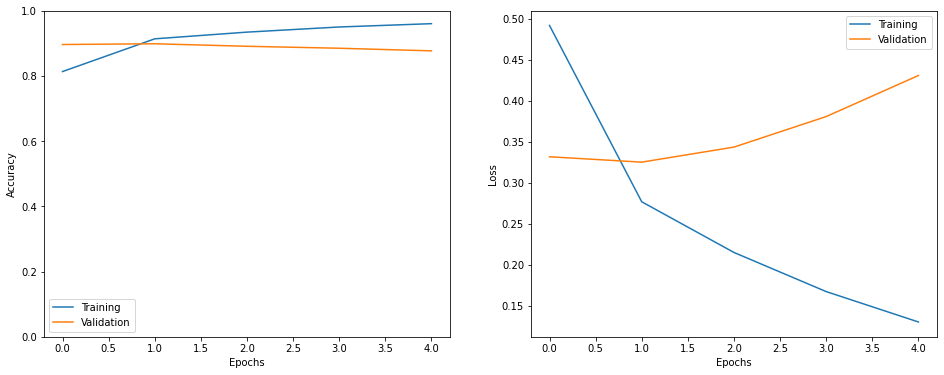

In [10]:
sentiment_classification1.show_history(h = hist)

In [11]:
sentiment_classification1.evaluate_model(x_test, y_test_encoded)

1019/1019 [==============================] - 14s 13ms/step - loss: 0.4352 - accuracy: 0.8761


(0.4351966977119446, 0.8760508298873901)

1019/1019 [==============================] - 15s 13ms/step


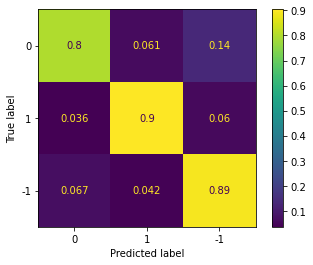

In [12]:
sentiment_classification1.print_confusion_matrix(x_test, y_test_encoded)